In [1]:
import regex
import tarfile
from pprint import pprint
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
def read_archive(path):
    tar = tarfile.open(path, "r:gz")   
    files = {}
    for filename in tar.getnames():
        f = tar.extractfile(filename)
        files[filename] = f.read().decode("utf-8").replace('\n', ' ').replace('\t', ' ')
    return files

In [3]:
def find_matches(regexes, flections):
    matches=[sum(
            [len(
                regex.findall(r, f, flags=regex.IGNORECASE))
             for k,f in files.items()])
        for r in regexes]
    return dict(zip(flections,matches))

# Zadanie 1

In [4]:
# source: 
# ROZPORZĄDZENIE
# PREZESA RADY MINISTRÓW/
# z dnia 20 czerwca 2002 r.
# w sprawie "Zasad techniki prawodawczej" §85

#https://sip.lex.pl/akty-prawne/dzu-dziennik-ustaw/zasady-techniki-prawodawczej-16968290

item_types=r'(art\.|ust\.|pkt|lit\.)'
additions_r='('+item_types+r'\s+\d+\s+dodaje\s+się\s+'+item_types+')'
removals_r=r'uchyla\s+się\s+'+item_types
removals2_r=r'skreśla\s+się'+item_types
mods_r=item_types+'\s+\d+\s+otrzymuje\s+brzmienie'
files = read_archive('ustawy.tar.gz')
# print(additions)

additions={k:[a[0] for a in regex.findall(additions_r, f, flags=regex.IGNORECASE)] for k,f in files.items()}
removals={k:[a[0] for a in regex.findall("|".join([removals_r, removals2_r]), f, flags=regex.IGNORECASE)] for k,f in files.items()}
mods={k:[a[0] for a in regex.findall(mods_r, f, flags=regex.IGNORECASE)] for k,f in files.items()}

pprint(f'Additions: {sum([len(add) for _, add in additions.items()])}')
pprint(f'Deletions: {sum([len(rem) for _, rem in removals.items()])}')
pprint(f'Modified: {sum([len(mod) for _, mod in mods.items()])}')

# pprint(additions)

'Additions: 3480'
'Deletions: 566'
'Modified: 7766'


# Zadanie 3

In [5]:
dates = {k:regex.findall("((Ustawa|U S T A W A).*?\s+z\s+dnia\s+(.*?)(\d\d\d\d)\s*r\.)", f, flags=regex.IGNORECASE)[:1] for k, f in files.items()}

dates={filename:data[0][3] for (filename, data) in dates.items() if len(data)>0}

In [6]:
def aggregate_years(data, dates, label):
    res={}
    for filename, val in data.items():
        if filename in dates:
            year=dates[filename]
            if year in res:
                res[year] += len(val)
            else:
                res[year] = len(val)
                
    res = pd.DataFrame(res, index=[0]).transpose()
    res.rename(columns={0: label}, inplace=True)
    return res

,added,removed,modified,sum,padd,prem,pmod
1993,13,0,56,69,0.188406,0.000000,0.811594
1994,52,0,72,124,0.419355,0.000000,0.580645
1995,184,0,321,505,0.364356,0.000000,0.635644
1996,166,0,398,564,0.294326,0.000000,0.705674
1997,305,0,620,925,0.329730,0.000000,0.670270
1998,268,1,765,1034,0.259188,0.000967,0.739845
1999,111,4,185,300,0.370000,0.013333,0.616667
2000,494,0,1262,1756,0.281321,0.000000,0.718679
2001,619,0,1267,1886,0.328208,0.000000,0.671792
2002,11,0,28,39,0.282051,0.000000,0.717949


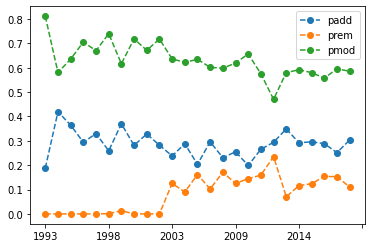

In [7]:
addition_years=aggregate_years(additions, dates, 'added')
removal_years=aggregate_years(removals, dates, 'removed')
mods_years=aggregate_years(mods, dates, 'modified')

data=addition_years.join(removal_years).join(mods_years)

data['sum']=data['added']+data['removed']+data['modified']
data['padd']=data['added']/data['sum']
data['prem']=data['removed']/data['sum']
data['pmod']=data['modified']/data['sum']


data=data.sort_index()
data.plot(y=['padd', 'prem', 'pmod'], style='o--')
data

# Zadanie 4

In [8]:
#got from https://sjp.pl/ustawa
flections=['ustawa', 'ustawą', 'ustawę', 'ustawie', 'ustawo', 'ustawy', 'ustawach', 'ustawami', 'ustawom', 'ustaw']

In [9]:
r = r'\b('+r' | '.join(flections)+ r')\b'
regexes=[r'\b'+f +r'\b' for f in flections]

In [10]:
r

'\\b(ustawa | ustawą | ustawę | ustawie | ustawo | ustawy | ustawach | ustawami | ustawom | ustaw)\\b'

In [11]:
files = read_archive('ustawy.tar.gz')
matches4=find_matches(regexes, flections)

In [12]:
matches4

{'ustawa': 3235,
 'ustawą': 1118,
 'ustawę': 829,
 'ustawie': 5478,
 'ustawo': 0,
 'ustawy': 13099,
 'ustawach': 178,
 'ustawami': 76,
 'ustawom': 12,
 'ustaw': 909}

## Edge case: ustaw as verb

In [13]:
scopes=[regex.findall(r'.{10}\bustaw\b.{10}', f, flags=regex.IGNORECASE)for k,f in files.items()]

result=[]
for s in scopes:
    if len(s) > 0:
        result += s
        
set(result)

{'          Ustaw Rzeczypos',
 '          ustaw          ',
 '          ustaw dotyczące',
 '          ustaw i rozporz',
 '          ustaw i ustawę ',
 '          ustaw lub przep',
 '          ustaw podatkowy',
 '          ustaw regulując',
 '          ustaw,         ',
 '          ustaw, biuro no',
 '          ustaw, umów lub',
 '     albo ustaw nie można',
 '    zmian ustaw  konstytu',
 '   innych ustaw          ',
 '   innych ustaw (Dz.U. Nr',
 '   innych ustaw i aktów w',
 '   innych ustaw należy do',
 '   innych ustaw.",    b) ',
 '  a także ustaw o zmianie',
 '  zmianie ustaw Kodeks cy',
 ' Dziennik Ustaw Rzeczypos',
 ' Dziennik Ustaw i Monitor',
 ' Dziennik Ustaw, Monitor ',
 ' Przepisy ustaw zmieniany',
 ' Przepisy ustaw, o któryc',
 ' i innych ustaw          ',
 ' i innych ustaw będę ściś',
 ' i innych ustaw oraz     ',
 ' i innych ustaw,         ',
 ' naruszeń ustaw dopuści  ',
 ' projekty ustaw, rozporzą',
 ' przepisy ustaw      odrę',
 ' przepisy ustaw   szczegó',
 ' przepis

not found


# Zadanie 5

In [14]:
regexes5 = [r+r' (?=\sz dnia)' for r in regexes]

In [15]:
regexes5

['\\bustawa\\b (?=\\sz dnia)',
 '\\bustawą\\b (?=\\sz dnia)',
 '\\bustawę\\b (?=\\sz dnia)',
 '\\bustawie\\b (?=\\sz dnia)',
 '\\bustawo\\b (?=\\sz dnia)',
 '\\bustawy\\b (?=\\sz dnia)',
 '\\bustawach\\b (?=\\sz dnia)',
 '\\bustawami\\b (?=\\sz dnia)',
 '\\bustawom\\b (?=\\sz dnia)',
 '\\bustaw\\b (?=\\sz dnia)']

In [16]:
files = read_archive('ustawy.tar.gz')
matches5=find_matches(regexes5, flections)

In [17]:
matches5

{'ustawa': 9,
 'ustawą': 0,
 'ustawę': 2,
 'ustawie': 10,
 'ustawo': 0,
 'ustawy': 10,
 'ustawach': 0,
 'ustawami': 0,
 'ustawom': 0,
 'ustaw': 0}

# Zadanie 6

In [18]:
regexes6 = [r+r'(?!\sz dnia)' for r in regexes]

In [19]:
regexes6

['\\bustawa\\b(?!\\sz dnia)',
 '\\bustawą\\b(?!\\sz dnia)',
 '\\bustawę\\b(?!\\sz dnia)',
 '\\bustawie\\b(?!\\sz dnia)',
 '\\bustawo\\b(?!\\sz dnia)',
 '\\bustawy\\b(?!\\sz dnia)',
 '\\bustawach\\b(?!\\sz dnia)',
 '\\bustawami\\b(?!\\sz dnia)',
 '\\bustawom\\b(?!\\sz dnia)',
 '\\bustaw\\b(?!\\sz dnia)']

In [20]:
files = read_archive('ustawy.tar.gz')
matches6=find_matches(regexes6, flections)

In [21]:
matches6

{'ustawa': 2869,
 'ustawą': 1063,
 'ustawę': 241,
 'ustawie': 1887,
 'ustawo': 0,
 'ustawy': 10280,
 'ustawach': 177,
 'ustawami': 76,
 'ustawom': 12,
 'ustaw': 909}

In [22]:
for k, v in matches4.items():
    print(k, v, matches5[k], matches6[k])

ustawa 3235 9 2869
ustawą 1118 0 1063
ustawę 829 2 241
ustawie 5478 10 1887
ustawo 0 0 0
ustawy 13099 10 10280
ustawach 178 0 177
ustawami 76 0 76
ustawom 12 0 12
ustaw 909 0 909


# Zadanie 7

In [23]:
regexes7 = [r'(?<!\bo\szmianie\b\s)'+r for r in regexes]

In [24]:
regexes7

['(?<!\\bo\\szmianie\\b\\s)\\bustawa\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawą\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawę\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawie\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawo\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawy\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawach\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawami\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawom\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustaw\\b']

In [25]:
files = read_archive('ustawy.tar.gz')
matches7=find_matches(regexes7, flections)

In [26]:
matches7

{'ustawa': 3235,
 'ustawą': 1118,
 'ustawę': 829,
 'ustawie': 5478,
 'ustawo': 0,
 'ustawy': 12263,
 'ustawach': 178,
 'ustawami': 76,
 'ustawom': 12,
 'ustaw': 893}

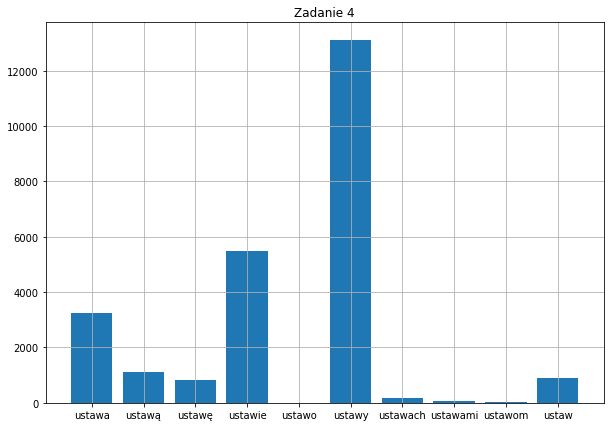

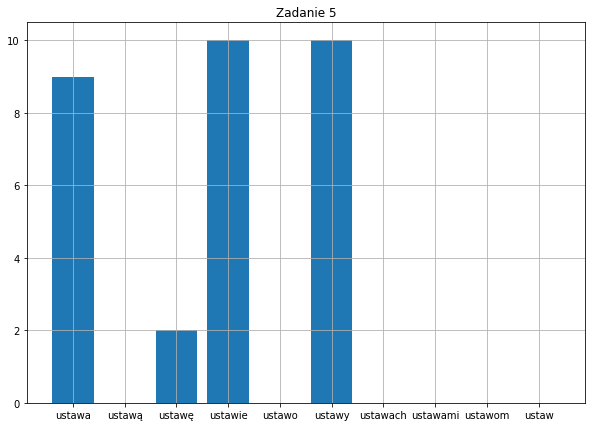

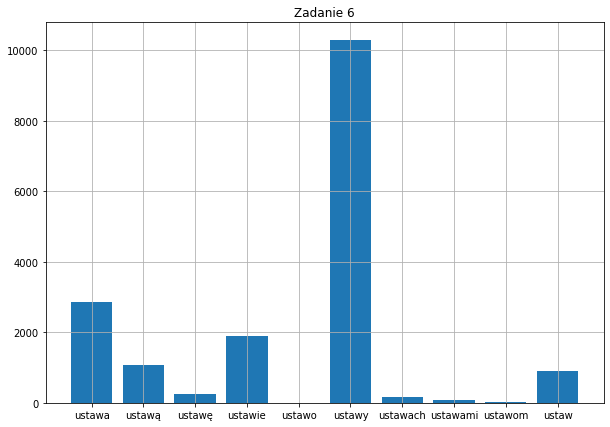

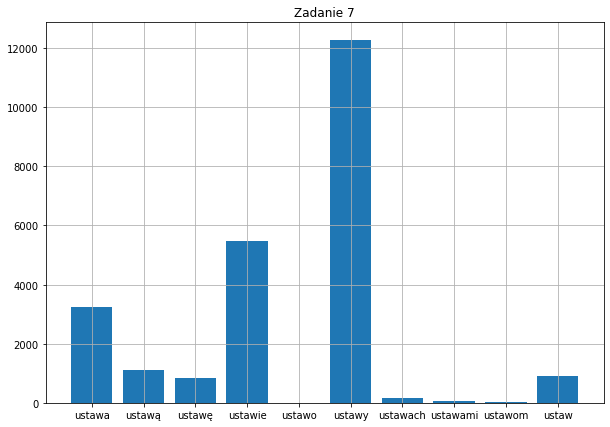

In [27]:
i=4
for m in [matches4, matches5, matches6, matches7]:
    plt.figure(figsize=(10, 7))
    plt.grid()
    plt.title(f"Zadanie {i}")
    plt.bar(m.keys(), m.values(), label=m.keys())
    plt.show()
    i+=1